# 1-IMPORT LIBRARIES

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [40]:
print("\n" + "="*80)
print("LOADING CLEANED DATA")
print("="*80)

# Load cleaned dataset
df = pd.read_csv('02_cleaned_data.csv')

print(f"✅ Data loaded: {df.shape[0]:,} samples, {df.shape[1]} features")

# Get feature columns (exclude targets)
final_features = [col for col in df.columns if col not in ['is_attack', 'label2']]

print(f"✅ Features: {len(final_features)}")
print(f"✅ Columns in dataset: {df.columns.tolist()}")


LOADING CLEANED DATA
✅ Data loaded: 685,671 samples, 42 features
✅ Features: 40
✅ Columns in dataset: ['network_packets_all_count', 'network_time-delta_min', 'network_ports_all_count', 'network_packet-size_min', 'network_ports_dst_count', 'network_time-delta_avg', 'network_packets_src_count', 'network_tcp-flags-syn_count', 'network_tcp-flags-ack_count', 'network_time-delta_max', 'network_mss_avg', 'network_tcp-flags_std_deviation', 'network_interval-packets', 'network_window-size_std_deviation', 'network_time-delta_std_deviation', 'network_window-size_avg', 'network_ips_all_count', 'network_ips_src_count', 'network_ip-length_avg', 'network_window-size_max', 'network_ttl_avg', 'network_window-size_min', 'network_ip-length_std_deviation', 'network_ip-length_max', 'network_ip-flags_std_deviation', 'network_ttl_std_deviation', 'network_ttl_min', 'network_tcp-flags_avg', 'network_payload-length_std_deviation', 'network_ip-length_min', 'network_ip-flags_avg', 'network_header-length_avg', 'n

## 2- Encoding labels

In [41]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(df['label2'])

print("\n" + "="*60)
print("Label Encoding Mapping:")
print("="*60)
for i, label in enumerate(le.classes_):
    count = sum(df['label2'] == label)
    print(f"  {i}: {label:15s} → {count:,} samples")



Label Encoding Mapping:
  0: benign          → 400,672 samples
  1: bruteforce      → 6,016 samples
  2: ddos            → 56,692 samples
  3: dos             → 57,736 samples
  4: malware         → 24,177 samples
  5: mitm            → 25,490 samples
  6: recon           → 105,848 samples
  7: web             → 9,040 samples


## 3- Train / Test split

In [42]:
X = df.drop(columns=['label2','is_attack'])  

# all columns except the labe
print(X.shape)
print(y_encoded.shape)
X.head()

(685671, 40)
(685671,)


,network_packets_all_count,network_time-delta_min,network_ports_all_count,network_packet-size_min,network_ports_dst_count,network_time-delta_avg,network_packets_src_count,network_tcp-flags-syn_count,network_tcp-flags-ack_count,network_time-delta_max,...,network_ip-flags_avg,network_header-length_avg,network_protocols_dst_count,network_fragmentation-score,network_ttl_max,network_fragmented-packets,log_messages_count,log_data-types_count,network_tcp-flags_min,network_tcp-flags_max
0,1,4.148100e-02,2,214.0,1,0.041481,1,0,0,0.041481,...,0.000000,20.0,0,0.00,255.0,0,0,0,0.0,0.0
1,6,2.960000e-04,2,60.0,2,0.025816,3,0,2,0.091281,...,2.000000,20.0,2,0.00,236.0,0,0,0,16.0,24.0
2,359,3.300000e-08,181,60.0,181,0.000634,181,177,180,0.017724,...,0.005587,20.0,2,0.00,255.0,0,0,0,2.0,24.0
3,107467,2.500000e-08,37905,60.0,6,0.000082,20,0,48233,0.028095,...,0.551005,20.0,12,12.92,255.0,59205,9,1,16.0,24.0
4,1,7.201200e-02,2,230.0,1,0.072012,1,0,0,0.072012,...,0.000000,20.0,0,0.00,255.0,0,0,0,0.0,0.0


In [43]:
from sklearn.model_selection import train_test_split
X = df[final_features]
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded  # Keep class balance
)

print("\n" + "="*60)
print("📂 Train/Test Split:")
print("="*60)
print(f"  Train: {X_train.shape[0]:,} samples")
print(f"  Test:  {X_test.shape[0]:,} samples")


📂 Train/Test Split:
  Train: 548,536 samples
  Test:  137,135 samples


In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled!")

✅ Features scaled!


## Model 1 : Train with XGboost

### 1.1 Training of model

In [45]:
print("\n" + "="*60)
print(" TRAINING MULTI-CLASS XGBOOST")
print("="*60)

xgb_multi = XGBClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=len(le.classes_),
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)
 
print("⏳ Training in progress...")
xgb_multi.fit(X_train_scaled, y_train)
print("✅ Training complete!")


 TRAINING MULTI-CLASS XGBOOST
⏳ Training in progress...
✅ Training complete!


### 1.2 Make predictions & overall performance

In [46]:
y_pred = xgb_multi.predict(X_test_scaled)
print("\n" + "="*80)
print("🎯 MULTI-CLASS CLASSIFICATION RESULTS")
print("="*80)

acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Overall Accuracy: {acc:.4f} ({acc*100:.2f}%)")
print("\n" + "="*60)
print("📊 Per-Class Performance (Precision, Recall, F1):")
print("="*60)
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))


🎯 MULTI-CLASS CLASSIFICATION RESULTS

🎯 Overall Accuracy: 0.9652 (96.52%)

📊 Per-Class Performance (Precision, Recall, F1):
              precision    recall  f1-score   support

      benign     0.9489    0.9978    0.9727     80135
  bruteforce     0.9971    0.8570    0.9218      1203
        ddos     0.9954    0.9330    0.9632     11339
         dos     0.9955    0.9674    0.9813     11547
     malware     0.9936    0.9566    0.9747      4835
        mitm     0.9821    0.9572    0.9695      5098
       recon     0.9869    0.8727    0.9263     21170
         web     1.0000    0.9060    0.9507      1808

    accuracy                         0.9652    137135
   macro avg     0.9874    0.9310    0.9575    137135
weighted avg     0.9664    0.9652    0.9647    137135



### 1.3 confusion matrix 

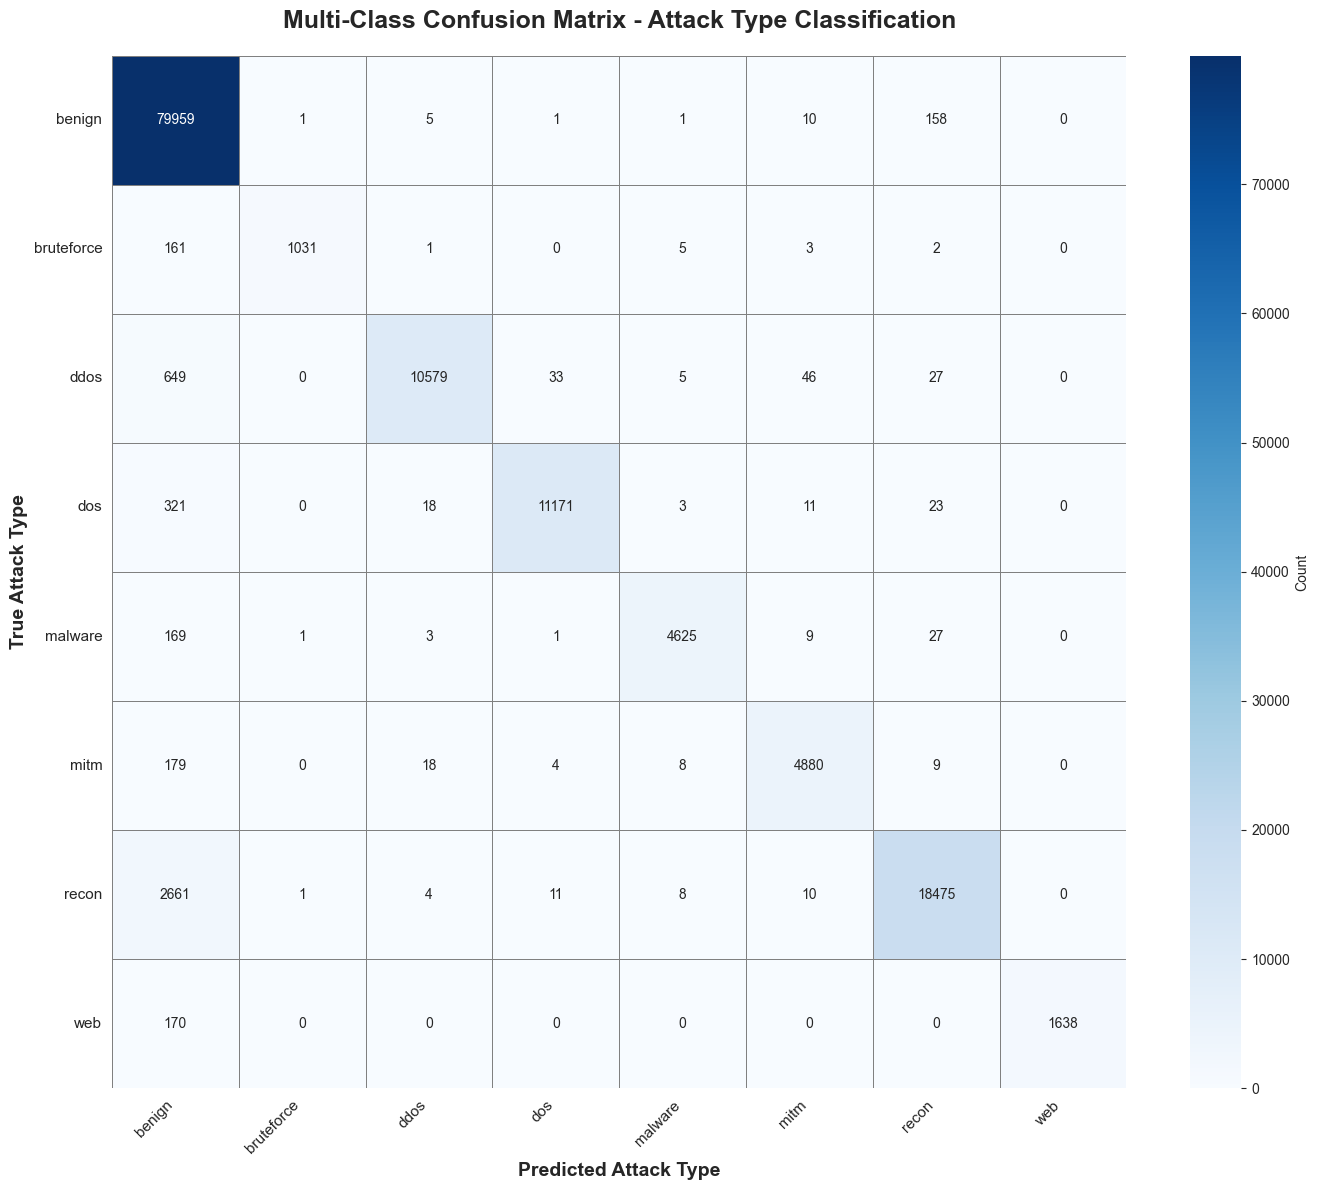

In [47]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_,
            cbar_kws={'label': 'Count'},
            linewidths=0.5,
            linecolor='gray')
plt.title('Multi-Class Confusion Matrix - Attack Type Classification', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Predicted Attack Type', fontsize=14, fontweight='bold')
plt.ylabel('True Attack Type', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

### 1.4 results breakdown

In [48]:
# ============================================
# ATTACK-BY-ATTACK BREAKDOWN
# ============================================
print("\n" + "="*60)
print("🔍 Detailed Breakdown by Attack Type:")
print("="*60)

for i, attack_type in enumerate(le.classes_):
    mask = y_test == i
    if sum(mask) > 0:
        correct = sum((y_test == i) & (y_pred == i))
        total = sum(mask)
        acc_class = correct / total
        
        # Emoji based on accuracy
        if acc_class >= 0.95:
            emoji = "🟢"
        elif acc_class >= 0.85:
            emoji = "🟡"
        else:
            emoji = "🔴"
            
        print(f"{emoji} {attack_type:15s}: {correct:5,}/{total:5,} correct ({acc_class*100:6.2f}%)")




🔍 Detailed Breakdown by Attack Type:
🟢 benign         : 79,959/80,135 correct ( 99.78%)
🟡 bruteforce     : 1,031/1,203 correct ( 85.70%)
🟡 ddos           : 10,579/11,339 correct ( 93.30%)
🟢 dos            : 11,171/11,547 correct ( 96.74%)
🟢 malware        : 4,625/4,835 correct ( 95.66%)
🟢 mitm           : 4,880/5,098 correct ( 95.72%)
🟡 recon          : 18,475/21,170 correct ( 87.27%)
🟡 web            : 1,638/1,808 correct ( 90.60%)


## Model 2 : Random Forest 

### 1.1 Training of model

In [49]:
rf_multi = RandomForestClassifier(
    n_estimators=500,
    max_depth=25,               # Prevents overfitting
    class_weight='balanced',    # Adjusts for class imbalance
    random_state=42,
    n_jobs=-1
)
rf_multi.fit(X_train_scaled, y_train) 
print("✅ Training complete!")

✅ Training complete!


### 1.2 Make predictions & overall performance

In [50]:
y_pred = rf_multi.predict(X_test_scaled)

# ============================================
# OVERALL ACCURACY
# ============================================
print("\n" + "="*80)
print("🎯 MULTI-CLASS CLASSIFICATION RESULTS")
print("="*80)

acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Overall Accuracy: {acc:.4f} ({acc*100:.2f}%)")

# ============================================
# DETAILED CLASSIFICATION REPORT (formatted)
# ============================================
report = classification_report(
    y_test, y_pred, 
    target_names=le.classes_, 
    digits=2
)
print("\nClassification Report:")
print(report)



🎯 MULTI-CLASS CLASSIFICATION RESULTS

🎯 Overall Accuracy: 0.9670 (96.70%)

Classification Report:
              precision    recall  f1-score   support

      benign       0.95      1.00      0.97     80135
  bruteforce       0.99      0.86      0.92      1203
        ddos       0.99      0.93      0.96     11339
         dos       1.00      0.97      0.98     11547
     malware       0.99      0.96      0.97      4835
        mitm       0.97      0.96      0.97      5098
       recon       0.99      0.89      0.93     21170
         web       1.00      0.91      0.95      1808

    accuracy                           0.97    137135
   macro avg       0.99      0.93      0.96    137135
weighted avg       0.97      0.97      0.97    137135



### 1.3 confusion matrix

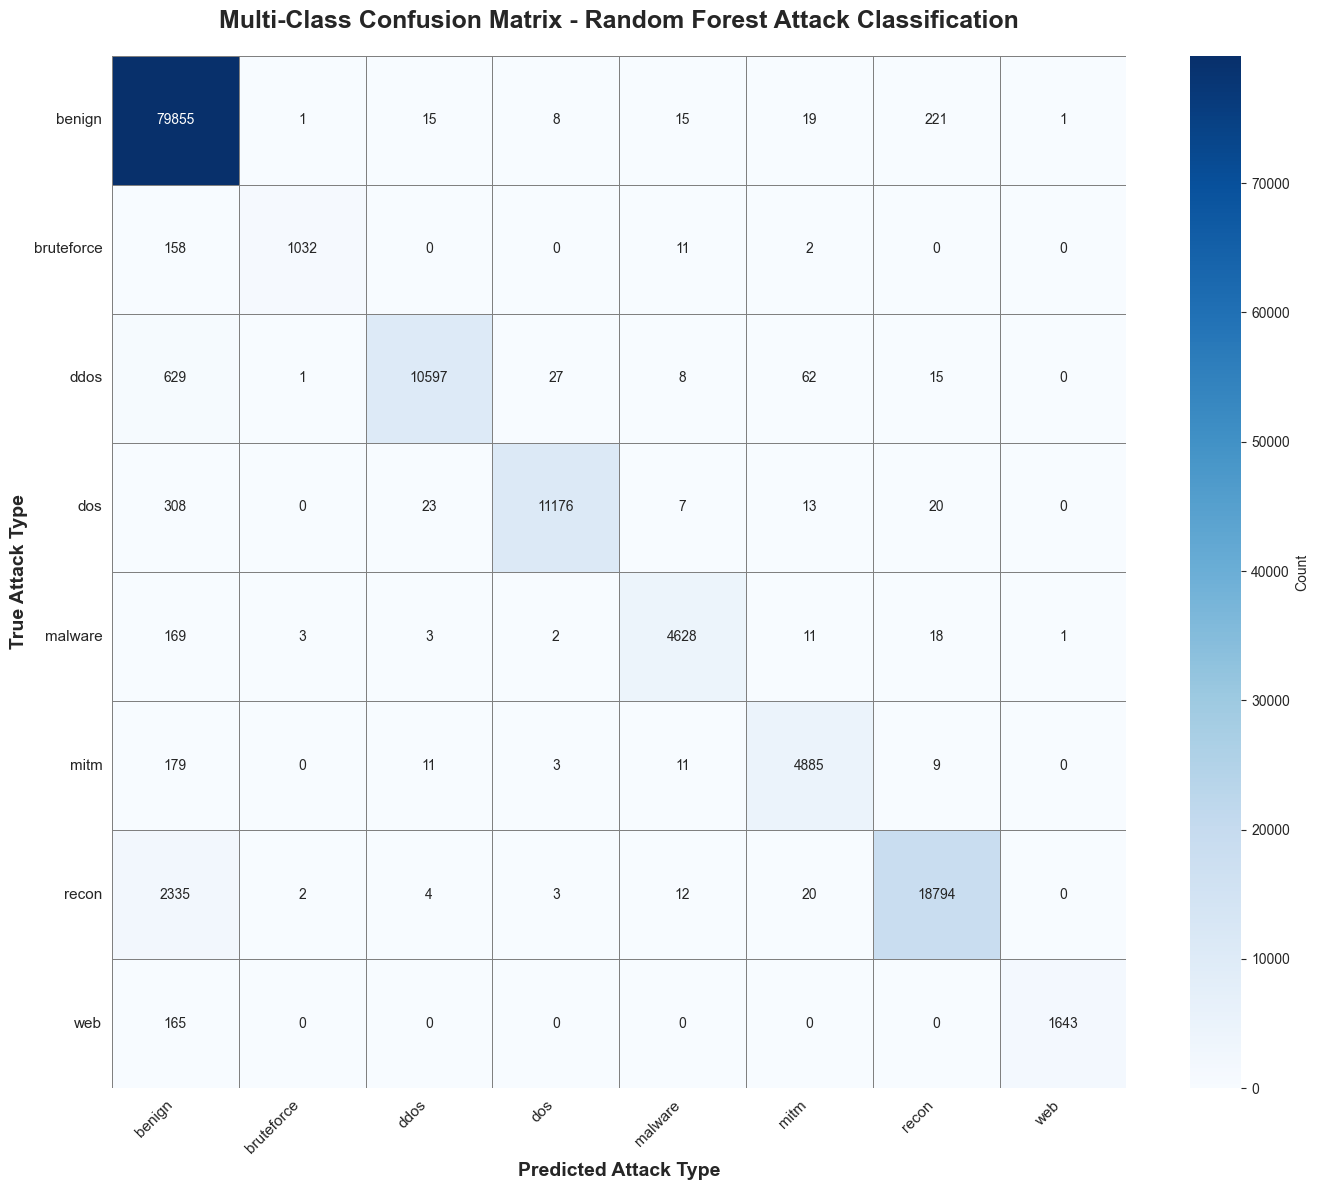

In [51]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cbar_kws={'label': 'Count'},
            linewidths=0.5,
            linecolor='gray')
plt.title('Multi-Class Confusion Matrix - Random Forest Attack Classification',
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Predicted Attack Type', fontsize=14, fontweight='bold')
plt.ylabel('True Attack Type', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

### 1.4 Results Breakdown

In [52]:
print("\n" + "="*60)
print("🔍 Detailed Breakdown by Attack Type:")
print("="*60)

for i, attack_type in enumerate(le.classes_):
    mask = y_test == i
    if sum(mask) > 0:
        correct = sum((y_test == i) & (y_pred == i))
        total = sum(mask)
        acc_class = correct / total

        # Emoji based on accuracy
        if acc_class >= 0.95:
            emoji = "🟢"
        elif acc_class >= 0.85:
            emoji = "🟡"
        else:
            emoji = "🔴"

        print(f"{emoji} {attack_type:15s}: {correct:5,}/{total:5,} correct ({acc_class*100:6.2f}%)")


🔍 Detailed Breakdown by Attack Type:
🟢 benign         : 79,855/80,135 correct ( 99.65%)
🟡 bruteforce     : 1,032/1,203 correct ( 85.79%)
🟡 ddos           : 10,597/11,339 correct ( 93.46%)
🟢 dos            : 11,176/11,547 correct ( 96.79%)
🟢 malware        : 4,628/4,835 correct ( 95.72%)
🟢 mitm           : 4,885/5,098 correct ( 95.82%)
🟡 recon          : 18,794/21,170 correct ( 88.78%)
🟡 web            : 1,643/1,808 correct ( 90.87%)


# Model 3 : Light  GBM

### 1.1 Training of model 

In [86]:
    pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [57]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=1000,            # more boosting rounds
    max_depth=-1,                  # let it fully grow
    learning_rate=0.05,            # slower learning
    class_weight='balanced',       # important: treat minority classes as more important
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("⏳ Training LightGBM...")
lgbm.fit(X_train_scaled, y_train)
print("✅ Training complete!")


⏳ Training LightGBM...
✅ Training complete!


### 1.2 Make predictions & Overall performances

In [58]:
y_pred_lgbm = lgbm.predict(X_test_scaled)

# Evaluation
acc = accuracy_score(y_test, y_pred_lgbm)
f1 = f1_score(y_test, y_pred_lgbm, average='weighted')

print(f"\n🎯 Test Set Performance:")
print(f"   Accuracy: {acc:.4f}")
print(f"   F1-Score: {f1:.4f}")

# Per-class breakdown
print("\n📋 Per-Class Performance:")
for i, attack_type in enumerate(le.classes_):
    mask = y_test == i
    if sum(mask) > 0:
        correct = sum((y_test == i) & (y_pred_lgbm == i))
        total = sum(mask)
        acc_class = correct / total
        emoji = "🟢" if acc_class >= 0.95 else "🟡" if acc_class >= 0.85 else "🔴"
        print(f"   {emoji} {attack_type:20s}: {correct:5,}/{total:5,} ({acc_class*100:5.1f}%)")


C:\Users\Microsoft\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🎯 Test Set Performance:
   Accuracy: 0.9633
   F1-Score: 0.9630

📋 Per-Class Performance:
   🟢 benign              : 79,272/80,135 ( 98.9%)
   🟡 bruteforce          : 1,034/1,203 ( 86.0%)
   🟡 ddos                : 10,635/11,339 ( 93.8%)
   🟢 dos                 : 11,192/11,547 ( 96.9%)
   🟢 malware             : 4,658/4,835 ( 96.3%)
   🟢 mitm                : 4,915/5,098 ( 96.4%)
   🟡 recon               : 18,756/21,170 ( 88.6%)
   🟡 web                 : 1,643/1,808 ( 90.9%)


### 1.3 Confusion Matrix 

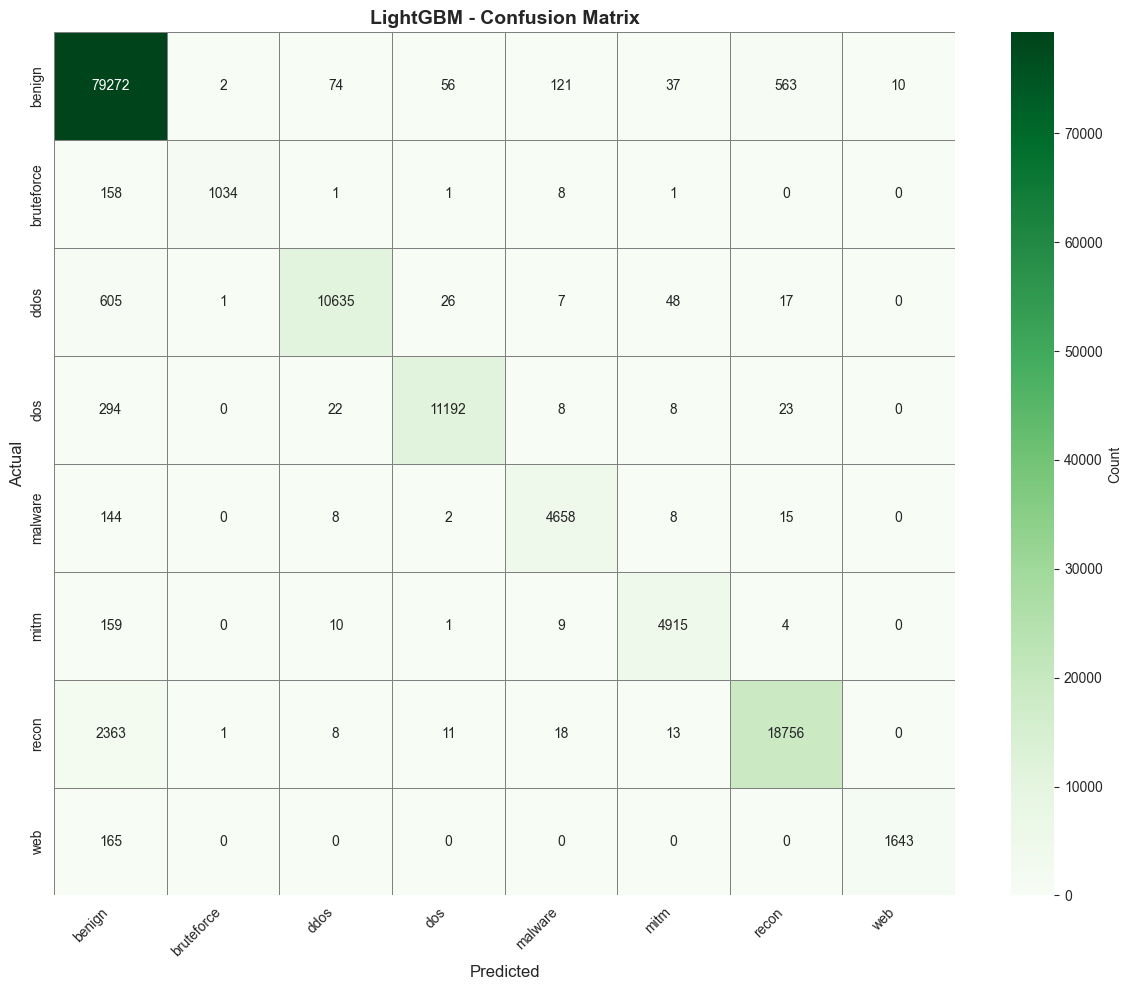

In [59]:
# Confusion Matrix
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cbar_kws={'label': 'Count'},
            linewidths=0.5,
            linecolor='gray')
plt.title('LightGBM - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()